In [1]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

##############
import os

from os import listdir
from os.path import isfile, join
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet152

In [2]:
currentPath = os.getcwd()
print(currentPath)

/home/ec2-user/SageMaker


In [3]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


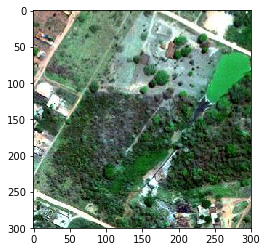

In [5]:
trainDB = currentPath + os.sep + "dataset" +  os.sep + "train20"
valDB = currentPath + os.sep + "dataset" +  os.sep + "val20"
data_set_path = currentPath + os.sep + "fMoW" + os.sep
Resnet152WeightsPretrained = currentPath + os.sep + "resnet152_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_name = "Resnet152"
classList = os.listdir(trainDB)
classList.sort()

img = mpimg.imread(trainDB + os.sep + "airport" + os.sep + "airport_7_8_msrgb.jpg")
imgplot = plt.imshow(img)

In [6]:
lr = 0.00016
batch_size = 20
num_epochs = 700
pre_train_epochs = 20

num_steps_per_epoch = 4
img_rows, img_cols, img_channel = 224, 224, 3
num_categories = len(classList)

In [7]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=270,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval = 0.)
    
train_generator = train_data_gen.flow_from_directory(
    directory=trainDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = ImageDataGenerator(
    rescale=1. / 225,
)
val_generator = val_data_gen.flow_from_directory(
    directory=valDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 927 images belonging to 62 classes.
Found 305 images belonging to 62 classes.


In [8]:
print(train_generator.class_indices)
imgs, labels = next(train_generator)

{'airport': 0, 'airport_hangar': 1, 'airport_terminal': 2, 'amusement_park': 3, 'aquaculture': 4, 'archaeological_site': 5, 'barn': 6, 'border_checkpoint': 7, 'burial_site': 8, 'car_dealership': 9, 'construction_site': 10, 'crop_field': 11, 'dam': 12, 'debris_or_rubble': 13, 'educational_institution': 14, 'electric_substation': 15, 'factory_or_powerplant': 16, 'fire_station': 17, 'flooded_road': 18, 'fountain': 19, 'gas_station': 20, 'golf_course': 21, 'ground_transportation_station': 22, 'helipad': 23, 'hospital': 24, 'impoverished_settlement': 25, 'interchange': 26, 'lake_or_pond': 27, 'lighthouse': 28, 'military_facility': 29, 'multi-unit_residential': 30, 'nuclear_powerplant': 31, 'office_building': 32, 'oil_or_gas_facility': 33, 'park': 34, 'parking_lot_or_garage': 35, 'place_of_worship': 36, 'police_station': 37, 'port': 38, 'prison': 39, 'race_track': 40, 'railway_bridge': 41, 'recreational_facility': 42, 'road_bridge': 43, 'runway': 44, 'shipyard': 45, 'shopping_mall': 46, 'sin

In [9]:
input = Input(shape=(img_rows, img_cols, img_channel))

In [10]:
def ResnetCustom(shape,pretrainedweights, input_tensor, classes):
    RN152NoTop = ResNet152(
        include_top=False, weights=pretrainedweights, input_tensor=input_tensor, input_shape=shape)
    
    RN152Out = RN152NoTop.layers[-1].output
    x = GlobalAvgPool2D()(RN152Out)
    output = Dense(classes, activation="softmax")(x)
    model = Model(input_tensor, output)
        
    return model

In [11]:
model = ResnetCustom((img_rows, img_cols, img_channel),Resnet152WeightsPretrained, input, num_categories)

model.summary()
#plot_model(model, show_shapes=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________

In [12]:
#optimizeFunc = SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=1e-6)
optimizeFunc = Adam(learning_rate=lr)
#model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizeFunc, loss='binary_crossentropy', metrics=[tensorflow.keras.metrics.CategoricalAccuracy()])

In [13]:
history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    steps_per_epoch=num_steps_per_epoch,
    # initial_epoch=pre_train_epochs,
    epochs=num_epochs,
    validation_steps=num_steps_per_epoch,
    callbacks=[ReduceLROnPlateau()],
    verbose=1)

Epoch 1/700
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
4/4 [==============================] - 68s 17s/step - loss: 0.0890 - categorical_accuracy: 0.0250 - val_loss: 0.0939 - val_categorical_accuracy: 0.0000e+00
Epoch 2/700
4/4 [==============================] - 7s 2s/step - loss: 0.0881 - categorical_accuracy: 0.0000e+00 - val_loss: 0.1669 - val_categorical_accuracy: 0.0000e+00
Epoch 3/700
4/4 [==============================] - 7s 2s/step - loss: 0.0861 - categorical_accuracy: 0.0625 - val_loss: 0.2598 - val_categorical_accuracy: 0.0375
Epoch 4/700
4/4 [==============================] - 7s 2s/step - loss: 0.0823 - categorical_accuracy: 0.0875 - val_loss: 0.2387 - val_categorical_accuracy: 0.0125
Epoch 5/700
4/4 [==============================] - 7s 2s/step - loss: 0.0814 - categorical_accuracy: 0.0500 - val_loss: 0.2081 - val_categorical_accuracy: 0.0125
Epoch 6/700
4/4 [==============================] - 7s 2s/step - loss: 0.0847 - cat

4/4 [==============================] - 8s 2s/step - loss: 0.0694 - categorical_accuracy: 0.1875 - val_loss: 0.1954 - val_categorical_accuracy: 0.0125
Epoch 23/700
4/4 [==============================] - 8s 2s/step - loss: 0.0707 - categorical_accuracy: 0.1625 - val_loss: 0.1878 - val_categorical_accuracy: 0.0125
Epoch 24/700
4/4 [==============================] - 8s 2s/step - loss: 0.0691 - categorical_accuracy: 0.1250 - val_loss: 0.1803 - val_categorical_accuracy: 0.0125
Epoch 25/700
4/4 [==============================] - 8s 2s/step - loss: 0.0708 - categorical_accuracy: 0.1750 - val_loss: 0.1726 - val_categorical_accuracy: 0.0125
Epoch 26/700
4/4 [==============================] - 8s 2s/step - loss: 0.0648 - categorical_accuracy: 0.1875 - val_loss: 0.1646 - val_categorical_accuracy: 0.0125
Epoch 27/700
4/4 [==============================] - 8s 2s/step - loss: 0.0694 - categorical_accuracy: 0.1625 - val_loss: 0.1576 - val_categorical_accuracy: 0.0125
Epoch 28/700
4/4 [=================

Epoch 45/700
4/4 [==============================] - 7s 2s/step - loss: 0.0680 - categorical_accuracy: 0.2388 - val_loss: 0.1035 - val_categorical_accuracy: 0.0125
Epoch 46/700
4/4 [==============================] - 8s 2s/step - loss: 0.0656 - categorical_accuracy: 0.1875 - val_loss: 0.1023 - val_categorical_accuracy: 0.0125
Epoch 47/700
4/4 [==============================] - 8s 2s/step - loss: 0.0668 - categorical_accuracy: 0.2375 - val_loss: 0.1012 - val_categorical_accuracy: 0.0125
Epoch 48/700
4/4 [==============================] - 8s 2s/step - loss: 0.0676 - categorical_accuracy: 0.2625 - val_loss: 0.1007 - val_categorical_accuracy: 0.0125
Epoch 49/700
4/4 [==============================] - 8s 2s/step - loss: 0.0667 - categorical_accuracy: 0.2000 - val_loss: 0.1001 - val_categorical_accuracy: 0.0125
Epoch 50/700
4/4 [==============================] - 8s 2s/step - loss: 0.0714 - categorical_accuracy: 0.1125 - val_loss: 0.0996 - val_categorical_accuracy: 0.0125
Epoch 51/700
4/4 [====

4/4 [==============================] - 8s 2s/step - loss: 0.0683 - categorical_accuracy: 0.1875 - val_loss: 0.0927 - val_categorical_accuracy: 0.0125
Epoch 68/700
4/4 [==============================] - 8s 2s/step - loss: 0.0688 - categorical_accuracy: 0.1625 - val_loss: 0.0925 - val_categorical_accuracy: 0.0125
Epoch 69/700
4/4 [==============================] - 8s 2s/step - loss: 0.0671 - categorical_accuracy: 0.1500 - val_loss: 0.0922 - val_categorical_accuracy: 0.0125
Epoch 70/700
4/4 [==============================] - 8s 2s/step - loss: 0.0700 - categorical_accuracy: 0.1750 - val_loss: 0.0920 - val_categorical_accuracy: 0.0125
Epoch 71/700
4/4 [==============================] - 8s 2s/step - loss: 0.0676 - categorical_accuracy: 0.1875 - val_loss: 0.0918 - val_categorical_accuracy: 0.0125
Epoch 72/700
4/4 [==============================] - 8s 2s/step - loss: 0.0706 - categorical_accuracy: 0.1625 - val_loss: 0.0916 - val_categorical_accuracy: 0.0125
Epoch 73/700
4/4 [=================

Epoch 90/700
4/4 [==============================] - 8s 2s/step - loss: 0.0673 - categorical_accuracy: 0.1750 - val_loss: 0.0905 - val_categorical_accuracy: 0.0125
Epoch 91/700
4/4 [==============================] - 8s 2s/step - loss: 0.0707 - categorical_accuracy: 0.1625 - val_loss: 0.0905 - val_categorical_accuracy: 0.0125
Epoch 92/700
4/4 [==============================] - 8s 2s/step - loss: 0.0686 - categorical_accuracy: 0.2000 - val_loss: 0.0905 - val_categorical_accuracy: 0.0125
Epoch 93/700
4/4 [==============================] - 8s 2s/step - loss: 0.0685 - categorical_accuracy: 0.2250 - val_loss: 0.0905 - val_categorical_accuracy: 0.0125
Epoch 94/700
4/4 [==============================] - 8s 2s/step - loss: 0.0666 - categorical_accuracy: 0.2250 - val_loss: 0.0904 - val_categorical_accuracy: 0.0125
Epoch 95/700
4/4 [==============================] - 7s 2s/step - loss: 0.0657 - categorical_accuracy: 0.1493 - val_loss: 0.0905 - val_categorical_accuracy: 0.0125
Epoch 96/700
4/4 [====

4/4 [==============================] - 8s 2s/step - loss: 0.0668 - categorical_accuracy: 0.2375 - val_loss: 0.0903 - val_categorical_accuracy: 0.0125
Epoch 113/700
4/4 [==============================] - 7s 2s/step - loss: 0.0680 - categorical_accuracy: 0.1940 - val_loss: 0.0902 - val_categorical_accuracy: 0.0125
Epoch 114/700
4/4 [==============================] - 8s 2s/step - loss: 0.0687 - categorical_accuracy: 0.1875 - val_loss: 0.0902 - val_categorical_accuracy: 0.0125
Epoch 115/700
4/4 [==============================] - 8s 2s/step - loss: 0.0714 - categorical_accuracy: 0.2000 - val_loss: 0.0903 - val_categorical_accuracy: 0.0125
Epoch 116/700
4/4 [==============================] - 8s 2s/step - loss: 0.0681 - categorical_accuracy: 0.2125 - val_loss: 0.0902 - val_categorical_accuracy: 0.0125
Epoch 117/700
4/4 [==============================] - 8s 2s/step - loss: 0.0693 - categorical_accuracy: 0.1625 - val_loss: 0.0903 - val_categorical_accuracy: 0.0125
Epoch 118/700
4/4 [===========

4/4 [==============================] - 7s 2s/step - loss: 0.0694 - categorical_accuracy: 0.1940 - val_loss: 0.0901 - val_categorical_accuracy: 0.0125
Epoch 135/700
4/4 [==============================] - 8s 2s/step - loss: 0.0700 - categorical_accuracy: 0.2000 - val_loss: 0.0900 - val_categorical_accuracy: 0.0125
Epoch 136/700
4/4 [==============================] - 8s 2s/step - loss: 0.0698 - categorical_accuracy: 0.1125 - val_loss: 0.0900 - val_categorical_accuracy: 0.0125
Epoch 137/700
4/4 [==============================] - 8s 2s/step - loss: 0.0699 - categorical_accuracy: 0.1875 - val_loss: 0.0900 - val_categorical_accuracy: 0.0125
Epoch 138/700
4/4 [==============================] - 8s 2s/step - loss: 0.0682 - categorical_accuracy: 0.2250 - val_loss: 0.0900 - val_categorical_accuracy: 0.0125
Epoch 139/700
4/4 [==============================] - 8s 2s/step - loss: 0.0699 - categorical_accuracy: 0.1375 - val_loss: 0.0900 - val_categorical_accuracy: 0.0125
Epoch 140/700
4/4 [===========

4/4 [==============================] - 8s 2s/step - loss: 0.0683 - categorical_accuracy: 0.2000 - val_loss: 0.0896 - val_categorical_accuracy: 0.0000e+00
Epoch 157/700
4/4 [==============================] - 8s 2s/step - loss: 0.0667 - categorical_accuracy: 0.2375 - val_loss: 0.0896 - val_categorical_accuracy: 0.0000e+00
Epoch 158/700
4/4 [==============================] - 8s 2s/step - loss: 0.0670 - categorical_accuracy: 0.2250 - val_loss: 0.0895 - val_categorical_accuracy: 0.0000e+00
Epoch 159/700
4/4 [==============================] - 8s 2s/step - loss: 0.0692 - categorical_accuracy: 0.2000 - val_loss: 0.0895 - val_categorical_accuracy: 0.0000e+00
Epoch 160/700
4/4 [==============================] - 8s 2s/step - loss: 0.0702 - categorical_accuracy: 0.1625 - val_loss: 0.0894 - val_categorical_accuracy: 0.0000e+00
Epoch 161/700
4/4 [==============================] - 8s 2s/step - loss: 0.0662 - categorical_accuracy: 0.1750 - val_loss: 0.0894 - val_categorical_accuracy: 0.0000e+00
Epoch 

4/4 [==============================] - 8s 2s/step - loss: 0.0682 - categorical_accuracy: 0.2000 - val_loss: 0.0885 - val_categorical_accuracy: 0.0125
Epoch 179/700
4/4 [==============================] - 8s 2s/step - loss: 0.0675 - categorical_accuracy: 0.1875 - val_loss: 0.0884 - val_categorical_accuracy: 0.0125
Epoch 180/700
4/4 [==============================] - 8s 2s/step - loss: 0.0649 - categorical_accuracy: 0.2375 - val_loss: 0.0884 - val_categorical_accuracy: 0.0125
Epoch 181/700
4/4 [==============================] - 8s 2s/step - loss: 0.0693 - categorical_accuracy: 0.2250 - val_loss: 0.0884 - val_categorical_accuracy: 0.0125
Epoch 182/700
4/4 [==============================] - 8s 2s/step - loss: 0.0728 - categorical_accuracy: 0.1375 - val_loss: 0.0883 - val_categorical_accuracy: 0.0125
Epoch 183/700
4/4 [==============================] - 8s 2s/step - loss: 0.0669 - categorical_accuracy: 0.2625 - val_loss: 0.0882 - val_categorical_accuracy: 0.0125
Epoch 184/700
4/4 [===========

Epoch 201/700
4/4 [==============================] - 8s 2s/step - loss: 0.0672 - categorical_accuracy: 0.2125 - val_loss: 0.0866 - val_categorical_accuracy: 0.0250
Epoch 202/700
4/4 [==============================] - 7s 2s/step - loss: 0.0705 - categorical_accuracy: 0.1493 - val_loss: 0.0865 - val_categorical_accuracy: 0.0250
Epoch 203/700
4/4 [==============================] - 8s 2s/step - loss: 0.0702 - categorical_accuracy: 0.1750 - val_loss: 0.0864 - val_categorical_accuracy: 0.0250
Epoch 204/700
4/4 [==============================] - 8s 2s/step - loss: 0.0672 - categorical_accuracy: 0.1625 - val_loss: 0.0863 - val_categorical_accuracy: 0.0125
Epoch 205/700
4/4 [==============================] - 8s 2s/step - loss: 0.0703 - categorical_accuracy: 0.1875 - val_loss: 0.0861 - val_categorical_accuracy: 0.0125
Epoch 206/700
4/4 [==============================] - 8s 2s/step - loss: 0.0712 - categorical_accuracy: 0.1750 - val_loss: 0.0860 - val_categorical_accuracy: 0.0125
Epoch 207/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.0700 - categorical_accuracy: 0.1500 - val_loss: 0.0842 - val_categorical_accuracy: 0.0125
Epoch 224/700
4/4 [==============================] - 8s 2s/step - loss: 0.0659 - categorical_accuracy: 0.1875 - val_loss: 0.0841 - val_categorical_accuracy: 0.0250
Epoch 225/700
4/4 [==============================] - 8s 2s/step - loss: 0.0658 - categorical_accuracy: 0.2750 - val_loss: 0.0839 - val_categorical_accuracy: 0.0250
Epoch 226/700
4/4 [==============================] - 8s 2s/step - loss: 0.0711 - categorical_accuracy: 0.1750 - val_loss: 0.0839 - val_categorical_accuracy: 0.0250
Epoch 227/700
4/4 [==============================] - 8s 2s/step - loss: 0.0658 - categorical_accuracy: 0.2500 - val_loss: 0.0838 - val_categorical_accuracy: 0.0250
Epoch 228/700
4/4 [==============================] - 8s 2s/step - loss: 0.0710 - categorical_accuracy: 0.1750 - val_loss: 0.0837 - val_categorical_accuracy: 0.0250
Epoch 229/700
4/4 [===========

Epoch 246/700
4/4 [==============================] - 8s 2s/step - loss: 0.0670 - categorical_accuracy: 0.1750 - val_loss: 0.0814 - val_categorical_accuracy: 0.0375
Epoch 247/700
4/4 [==============================] - 8s 2s/step - loss: 0.0670 - categorical_accuracy: 0.2125 - val_loss: 0.0813 - val_categorical_accuracy: 0.0500
Epoch 248/700
4/4 [==============================] - 8s 2s/step - loss: 0.0678 - categorical_accuracy: 0.2250 - val_loss: 0.0812 - val_categorical_accuracy: 0.0500
Epoch 249/700
4/4 [==============================] - 8s 2s/step - loss: 0.0661 - categorical_accuracy: 0.2750 - val_loss: 0.0810 - val_categorical_accuracy: 0.0500
Epoch 250/700
4/4 [==============================] - 8s 2s/step - loss: 0.0699 - categorical_accuracy: 0.2125 - val_loss: 0.0809 - val_categorical_accuracy: 0.0500
Epoch 251/700
4/4 [==============================] - 8s 2s/step - loss: 0.0724 - categorical_accuracy: 0.1000 - val_loss: 0.0808 - val_categorical_accuracy: 0.0625
Epoch 252/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.0688 - categorical_accuracy: 0.2000 - val_loss: 0.0790 - val_categorical_accuracy: 0.1000
Epoch 269/700
4/4 [==============================] - 8s 2s/step - loss: 0.0689 - categorical_accuracy: 0.2250 - val_loss: 0.0788 - val_categorical_accuracy: 0.1000
Epoch 270/700
4/4 [==============================] - 8s 2s/step - loss: 0.0671 - categorical_accuracy: 0.2000 - val_loss: 0.0787 - val_categorical_accuracy: 0.1000
Epoch 271/700
4/4 [==============================] - 8s 2s/step - loss: 0.0683 - categorical_accuracy: 0.2125 - val_loss: 0.0786 - val_categorical_accuracy: 0.1000
Epoch 272/700
4/4 [==============================] - 8s 2s/step - loss: 0.0643 - categorical_accuracy: 0.2500 - val_loss: 0.0785 - val_categorical_accuracy: 0.1000
Epoch 273/700
4/4 [==============================] - 8s 2s/step - loss: 0.0660 - categorical_accuracy: 0.2125 - val_loss: 0.0784 - val_categorical_accuracy: 0.1000
Epoch 274/700
4/4 [===========

Epoch 291/700
4/4 [==============================] - 7s 2s/step - loss: 0.0709 - categorical_accuracy: 0.1940 - val_loss: 0.0766 - val_categorical_accuracy: 0.1125
Epoch 292/700
4/4 [==============================] - 8s 2s/step - loss: 0.0688 - categorical_accuracy: 0.1625 - val_loss: 0.0765 - val_categorical_accuracy: 0.1125
Epoch 293/700
4/4 [==============================] - 8s 2s/step - loss: 0.0698 - categorical_accuracy: 0.1500 - val_loss: 0.0765 - val_categorical_accuracy: 0.1125
Epoch 294/700
4/4 [==============================] - 8s 2s/step - loss: 0.0731 - categorical_accuracy: 0.1500 - val_loss: 0.0764 - val_categorical_accuracy: 0.1125
Epoch 295/700
4/4 [==============================] - 8s 2s/step - loss: 0.0670 - categorical_accuracy: 0.2250 - val_loss: 0.0763 - val_categorical_accuracy: 0.1125
Epoch 296/700
4/4 [==============================] - 8s 2s/step - loss: 0.0700 - categorical_accuracy: 0.1375 - val_loss: 0.0762 - val_categorical_accuracy: 0.1125
Epoch 297/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.0669 - categorical_accuracy: 0.2500 - val_loss: 0.0753 - val_categorical_accuracy: 0.1125
Epoch 314/700
4/4 [==============================] - 8s 2s/step - loss: 0.0653 - categorical_accuracy: 0.2750 - val_loss: 0.0753 - val_categorical_accuracy: 0.1125
Epoch 315/700
4/4 [==============================] - 8s 2s/step - loss: 0.0671 - categorical_accuracy: 0.2375 - val_loss: 0.0752 - val_categorical_accuracy: 0.1125
Epoch 316/700
4/4 [==============================] - 8s 2s/step - loss: 0.0718 - categorical_accuracy: 0.1375 - val_loss: 0.0751 - val_categorical_accuracy: 0.1000
Epoch 317/700
4/4 [==============================] - 8s 2s/step - loss: 0.0721 - categorical_accuracy: 0.1500 - val_loss: 0.0752 - val_categorical_accuracy: 0.0875
Epoch 318/700
4/4 [==============================] - 7s 2s/step - loss: 0.0687 - categorical_accuracy: 0.1642 - val_loss: 0.0751 - val_categorical_accuracy: 0.0875
Epoch 319/700
4/4 [===========

Epoch 336/700
4/4 [==============================] - 8s 2s/step - loss: 0.0679 - categorical_accuracy: 0.2125 - val_loss: 0.0748 - val_categorical_accuracy: 0.0875
Epoch 337/700
4/4 [==============================] - 8s 2s/step - loss: 0.0669 - categorical_accuracy: 0.1750 - val_loss: 0.0748 - val_categorical_accuracy: 0.0875
Epoch 338/700
4/4 [==============================] - 8s 2s/step - loss: 0.0657 - categorical_accuracy: 0.2500 - val_loss: 0.0748 - val_categorical_accuracy: 0.0875
Epoch 339/700
4/4 [==============================] - 8s 2s/step - loss: 0.0705 - categorical_accuracy: 0.1625 - val_loss: 0.0748 - val_categorical_accuracy: 0.0875
Epoch 340/700
4/4 [==============================] - 7s 2s/step - loss: 0.0684 - categorical_accuracy: 0.1791 - val_loss: 0.0748 - val_categorical_accuracy: 0.0875
Epoch 341/700
4/4 [==============================] - 8s 2s/step - loss: 0.0721 - categorical_accuracy: 0.1500 - val_loss: 0.0747 - val_categorical_accuracy: 0.0875
Epoch 342/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.0653 - categorical_accuracy: 0.2750 - val_loss: 0.0746 - val_categorical_accuracy: 0.0875
Epoch 359/700
4/4 [==============================] - 8s 2s/step - loss: 0.0691 - categorical_accuracy: 0.2125 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 360/700
4/4 [==============================] - 8s 2s/step - loss: 0.0717 - categorical_accuracy: 0.1625 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 361/700
4/4 [==============================] - 8s 2s/step - loss: 0.0654 - categorical_accuracy: 0.2250 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 362/700
4/4 [==============================] - 8s 2s/step - loss: 0.0662 - categorical_accuracy: 0.2250 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 363/700
4/4 [==============================] - 8s 2s/step - loss: 0.0681 - categorical_accuracy: 0.2000 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 364/700
4/4 [===========

Epoch 381/700
4/4 [==============================] - 8s 2s/step - loss: 0.0677 - categorical_accuracy: 0.2625 - val_loss: 0.0747 - val_categorical_accuracy: 0.0875
Epoch 382/700
4/4 [==============================] - 8s 2s/step - loss: 0.0680 - categorical_accuracy: 0.2000 - val_loss: 0.0746 - val_categorical_accuracy: 0.0875
Epoch 383/700
4/4 [==============================] - 8s 2s/step - loss: 0.0687 - categorical_accuracy: 0.2000 - val_loss: 0.0746 - val_categorical_accuracy: 0.0875
Epoch 384/700
4/4 [==============================] - 8s 2s/step - loss: 0.0690 - categorical_accuracy: 0.2375 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 385/700
4/4 [==============================] - 8s 2s/step - loss: 0.0668 - categorical_accuracy: 0.2250 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 386/700
4/4 [==============================] - 8s 2s/step - loss: 0.0694 - categorical_accuracy: 0.1875 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 387/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.0680 - categorical_accuracy: 0.2125 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 404/700
4/4 [==============================] - 8s 2s/step - loss: 0.0669 - categorical_accuracy: 0.1625 - val_loss: 0.0747 - val_categorical_accuracy: 0.0750
Epoch 405/700
4/4 [==============================] - 8s 2s/step - loss: 0.0689 - categorical_accuracy: 0.1625 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 406/700
4/4 [==============================] - 8s 2s/step - loss: 0.0669 - categorical_accuracy: 0.2125 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 407/700
4/4 [==============================] - 8s 2s/step - loss: 0.0656 - categorical_accuracy: 0.3250 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 408/700
4/4 [==============================] - 7s 2s/step - loss: 0.0638 - categorical_accuracy: 0.2985 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 409/700
4/4 [===========

Epoch 426/700
4/4 [==============================] - 8s 2s/step - loss: 0.0662 - categorical_accuracy: 0.2125 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 427/700
4/4 [==============================] - 8s 2s/step - loss: 0.0724 - categorical_accuracy: 0.1500 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 428/700
4/4 [==============================] - 7s 2s/step - loss: 0.0695 - categorical_accuracy: 0.2090 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 429/700
4/4 [==============================] - 8s 2s/step - loss: 0.0672 - categorical_accuracy: 0.2000 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 430/700
4/4 [==============================] - 8s 2s/step - loss: 0.0697 - categorical_accuracy: 0.1125 - val_loss: 0.0747 - val_categorical_accuracy: 0.0750
Epoch 431/700
4/4 [==============================] - 8s 2s/step - loss: 0.0663 - categorical_accuracy: 0.2125 - val_loss: 0.0747 - val_categorical_accuracy: 0.0750
Epoch 432/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.0612 - categorical_accuracy: 0.2375 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 449/700
4/4 [==============================] - 8s 2s/step - loss: 0.0665 - categorical_accuracy: 0.2625 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 450/700
4/4 [==============================] - 8s 2s/step - loss: 0.0693 - categorical_accuracy: 0.2125 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 451/700
4/4 [==============================] - 8s 2s/step - loss: 0.0659 - categorical_accuracy: 0.2625 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 452/700
4/4 [==============================] - 8s 2s/step - loss: 0.0693 - categorical_accuracy: 0.2250 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 453/700
4/4 [==============================] - 8s 2s/step - loss: 0.0700 - categorical_accuracy: 0.1875 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 454/700
4/4 [===========

Epoch 471/700
4/4 [==============================] - 7s 2s/step - loss: 0.0689 - categorical_accuracy: 0.1642 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 472/700
4/4 [==============================] - 8s 2s/step - loss: 0.0706 - categorical_accuracy: 0.1500 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 473/700
4/4 [==============================] - 8s 2s/step - loss: 0.0693 - categorical_accuracy: 0.1625 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 474/700
4/4 [==============================] - 8s 2s/step - loss: 0.0680 - categorical_accuracy: 0.2000 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 475/700
4/4 [==============================] - 8s 2s/step - loss: 0.0702 - categorical_accuracy: 0.2125 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 476/700
4/4 [==============================] - 8s 2s/step - loss: 0.0671 - categorical_accuracy: 0.2625 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 477/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.0718 - categorical_accuracy: 0.1375 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 494/700
4/4 [==============================] - 7s 2s/step - loss: 0.0677 - categorical_accuracy: 0.2090 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 495/700
4/4 [==============================] - 8s 2s/step - loss: 0.0722 - categorical_accuracy: 0.1625 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 496/700
4/4 [==============================] - 8s 2s/step - loss: 0.0654 - categorical_accuracy: 0.2500 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 497/700
4/4 [==============================] - 8s 2s/step - loss: 0.0697 - categorical_accuracy: 0.1625 - val_loss: 0.0744 - val_categorical_accuracy: 0.0750
Epoch 498/700
4/4 [==============================] - 8s 2s/step - loss: 0.0684 - categorical_accuracy: 0.1625 - val_loss: 0.0744 - val_categorical_accuracy: 0.0750
Epoch 499/700
4/4 [===========

Epoch 516/700
4/4 [==============================] - 8s 2s/step - loss: 0.0666 - categorical_accuracy: 0.2125 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 517/700
4/4 [==============================] - 8s 2s/step - loss: 0.0701 - categorical_accuracy: 0.1125 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 518/700
4/4 [==============================] - 8s 2s/step - loss: 0.0707 - categorical_accuracy: 0.1250 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 519/700
4/4 [==============================] - 8s 2s/step - loss: 0.0704 - categorical_accuracy: 0.1500 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 520/700
4/4 [==============================] - 8s 2s/step - loss: 0.0684 - categorical_accuracy: 0.2500 - val_loss: 0.0746 - val_categorical_accuracy: 0.0875
Epoch 521/700
4/4 [==============================] - 8s 2s/step - loss: 0.0684 - categorical_accuracy: 0.1750 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 522/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.0680 - categorical_accuracy: 0.1375 - val_loss: 0.0746 - val_categorical_accuracy: 0.0875
Epoch 539/700
4/4 [==============================] - 8s 2s/step - loss: 0.0659 - categorical_accuracy: 0.2000 - val_loss: 0.0746 - val_categorical_accuracy: 0.0875
Epoch 540/700
4/4 [==============================] - 8s 2s/step - loss: 0.0687 - categorical_accuracy: 0.2500 - val_loss: 0.0746 - val_categorical_accuracy: 0.0875
Epoch 541/700
4/4 [==============================] - 8s 2s/step - loss: 0.0652 - categorical_accuracy: 0.1875 - val_loss: 0.0747 - val_categorical_accuracy: 0.0875
Epoch 542/700
4/4 [==============================] - 7s 2s/step - loss: 0.0712 - categorical_accuracy: 0.1642 - val_loss: 0.0747 - val_categorical_accuracy: 0.0875
Epoch 543/700
4/4 [==============================] - 8s 2s/step - loss: 0.0672 - categorical_accuracy: 0.2750 - val_loss: 0.0747 - val_categorical_accuracy: 0.0875
Epoch 544/700
4/4 [===========

Epoch 561/700
4/4 [==============================] - 8s 2s/step - loss: 0.0729 - categorical_accuracy: 0.1000 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 562/700
4/4 [==============================] - 8s 2s/step - loss: 0.0686 - categorical_accuracy: 0.2000 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 563/700
4/4 [==============================] - 8s 2s/step - loss: 0.0710 - categorical_accuracy: 0.1375 - val_loss: 0.0746 - val_categorical_accuracy: 0.0875
Epoch 564/700
4/4 [==============================] - 8s 2s/step - loss: 0.0673 - categorical_accuracy: 0.2250 - val_loss: 0.0746 - val_categorical_accuracy: 0.0875
Epoch 565/700
4/4 [==============================] - 8s 2s/step - loss: 0.0691 - categorical_accuracy: 0.1500 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 566/700
4/4 [==============================] - 8s 2s/step - loss: 0.0674 - categorical_accuracy: 0.1625 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 567/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.0691 - categorical_accuracy: 0.2125 - val_loss: 0.0745 - val_categorical_accuracy: 0.0875
Epoch 584/700
4/4 [==============================] - 8s 2s/step - loss: 0.0682 - categorical_accuracy: 0.2000 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 585/700
4/4 [==============================] - 8s 2s/step - loss: 0.0660 - categorical_accuracy: 0.3000 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 586/700
4/4 [==============================] - 8s 2s/step - loss: 0.0676 - categorical_accuracy: 0.2000 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 587/700
4/4 [==============================] - 8s 2s/step - loss: 0.0707 - categorical_accuracy: 0.1375 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 588/700
4/4 [==============================] - 8s 2s/step - loss: 0.0703 - categorical_accuracy: 0.1625 - val_loss: 0.0745 - val_categorical_accuracy: 0.0875
Epoch 589/700
4/4 [===========

Epoch 606/700
4/4 [==============================] - 8s 2s/step - loss: 0.0710 - categorical_accuracy: 0.1625 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 607/700
4/4 [==============================] - 8s 2s/step - loss: 0.0706 - categorical_accuracy: 0.1125 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 608/700
4/4 [==============================] - 8s 2s/step - loss: 0.0699 - categorical_accuracy: 0.1125 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 609/700
4/4 [==============================] - 8s 2s/step - loss: 0.0700 - categorical_accuracy: 0.1500 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 610/700
4/4 [==============================] - 8s 2s/step - loss: 0.0688 - categorical_accuracy: 0.2000 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 611/700
4/4 [==============================] - 8s 2s/step - loss: 0.0672 - categorical_accuracy: 0.2000 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 612/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.0688 - categorical_accuracy: 0.2000 - val_loss: 0.0746 - val_categorical_accuracy: 0.0875
Epoch 629/700
4/4 [==============================] - 8s 2s/step - loss: 0.0665 - categorical_accuracy: 0.2125 - val_loss: 0.0746 - val_categorical_accuracy: 0.0875
Epoch 630/700
4/4 [==============================] - 8s 2s/step - loss: 0.0693 - categorical_accuracy: 0.1500 - val_loss: 0.0746 - val_categorical_accuracy: 0.0875
Epoch 631/700
4/4 [==============================] - 8s 2s/step - loss: 0.0666 - categorical_accuracy: 0.2250 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 632/700
4/4 [==============================] - 8s 2s/step - loss: 0.0682 - categorical_accuracy: 0.2125 - val_loss: 0.0746 - val_categorical_accuracy: 0.0875
Epoch 633/700
4/4 [==============================] - 8s 2s/step - loss: 0.0717 - categorical_accuracy: 0.1875 - val_loss: 0.0746 - val_categorical_accuracy: 0.0875
Epoch 634/700
4/4 [===========

Epoch 651/700
4/4 [==============================] - 8s 2s/step - loss: 0.0687 - categorical_accuracy: 0.1750 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 652/700
4/4 [==============================] - 8s 2s/step - loss: 0.0703 - categorical_accuracy: 0.1625 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 653/700
4/4 [==============================] - 8s 2s/step - loss: 0.0684 - categorical_accuracy: 0.1500 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 654/700
4/4 [==============================] - 8s 2s/step - loss: 0.0700 - categorical_accuracy: 0.1875 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 655/700
4/4 [==============================] - 8s 2s/step - loss: 0.0702 - categorical_accuracy: 0.1375 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 656/700
4/4 [==============================] - 8s 2s/step - loss: 0.0705 - categorical_accuracy: 0.1125 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 657/700
4/

4/4 [==============================] - 8s 2s/step - loss: 0.0663 - categorical_accuracy: 0.2750 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 674/700
4/4 [==============================] - 7s 2s/step - loss: 0.0723 - categorical_accuracy: 0.1343 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 675/700
4/4 [==============================] - 8s 2s/step - loss: 0.0693 - categorical_accuracy: 0.1625 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 676/700
4/4 [==============================] - 8s 2s/step - loss: 0.0698 - categorical_accuracy: 0.1875 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 677/700
4/4 [==============================] - 8s 2s/step - loss: 0.0699 - categorical_accuracy: 0.1625 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 678/700
4/4 [==============================] - 8s 2s/step - loss: 0.0669 - categorical_accuracy: 0.2500 - val_loss: 0.0746 - val_categorical_accuracy: 0.0750
Epoch 679/700
4/4 [===========

Epoch 696/700
4/4 [==============================] - 8s 2s/step - loss: 0.0685 - categorical_accuracy: 0.2375 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 697/700
4/4 [==============================] - 8s 2s/step - loss: 0.0678 - categorical_accuracy: 0.2125 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 698/700
4/4 [==============================] - 8s 2s/step - loss: 0.0684 - categorical_accuracy: 0.2000 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 699/700
4/4 [==============================] - 8s 2s/step - loss: 0.0708 - categorical_accuracy: 0.1375 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750
Epoch 700/700
4/4 [==============================] - 8s 2s/step - loss: 0.0700 - categorical_accuracy: 0.1750 - val_loss: 0.0745 - val_categorical_accuracy: 0.0750


In [14]:
model.save(currentPath + os.sep + "Resnet152Model.h5")
model.save_weights(currentPath + os.sep + "Resnet152Weights.h5")

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


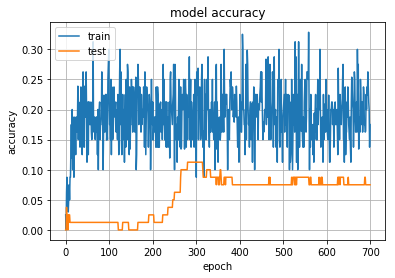

In [15]:
# Lets plot the results
print(history.history.keys())
# history accuracy
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

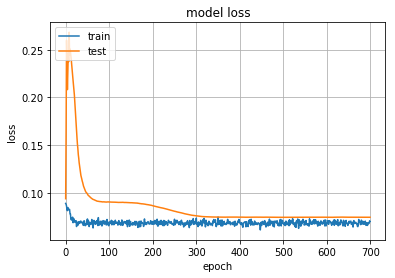

In [16]:
# history accuracy
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

In [17]:
# Lets predict
path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]

for file in imagesPredict:
    img = load_img(path + file, target_size=( img_rows, img_cols))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = model.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_26_1_msrgb.jpg is: space_facility
file airport_6_0_msrgb.jpg is: nuclear_powerplant
file airport_45_3_msrgb.jpg is: space_facility
file airport_55_0_msrgb.jpg is: airport


In [19]:
loadedModel = load_model("Resnet152Model.h5")

path = trainDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]
# print(imagesPredict)


for file in imagesPredict:
    img = load_img(path + file, target_size=( img_rows, img_cols))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = loadedModel.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_312_0_msrgb.jpg is: shipyard
file airport_431_0_msrgb.jpg is: runway
file airport_139_1_msrgb.jpg is: nuclear_powerplant
file airport_118_5_msrgb.jpg is: port
file airport_118_2_msrgb.jpg is: airport
file airport_211_1_msrgb.jpg is: runway
file airport_7_8_msrgb.jpg is: nuclear_powerplant
file airport_319_0_msrgb.jpg is: nuclear_powerplant
file airport_30_6_msrgb.jpg is: nuclear_powerplant
file airport_299_2_msrgb.jpg is: airport
file airport_118_7_msrgb.jpg is: airport
file airport_407_0_msrgb.jpg is: amusement_park
file airport_199_7_msrgb.jpg is: nuclear_powerplant
file airport_166_8_msrgb.jpg is: port
file airport_40_5_msrgb.jpg is: runway
